<Body>   
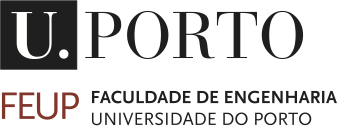   
<h1> <b>Computer Vision 2022/2023 </b> </h1>
<p><b>Andry Maykol Pinto </b> (amgp@fe.up.pt)</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# **Feature Analysis**

<h2>Table of contents</h2>
<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>
    <li><a href="#ref1">Feature Detection</a></li>
    <li><a href="#ref2">Feature Description and Matching</a></li>
    <li><a href="#ref3">Image Registration</a></li>
</ol>
<p></p>
</div>
<hr>

Software Requirements:

Please execute the following command to install the most recent version of OpenCV. This is necessary to utilize some of the functions we'll be needing in this lesson.



In [ ]:
pip install opencv-contrib-python==4.5.3.56

<a id="ref1"></a>
# Feature Detection

Upload the image 'example.jpg'.

In [ ]:
from google.colab import files
uploaded = files.upload()

In computer vision, a feature is a region of interest that is unique and easy to recognize. It can be an edge, a corner, or a particular color pattern, for example. In this lesson we will be studying keypoint features, which are described by the appearance of patches of pixels surrounding a point in the image. We will analyse both corner and blob-based keypoints.

**Corner Detection**

As you've learnt in class, a corner is an interception of two (or more) edges.
There are many algorithms for corner detection. We will be studying two of them: Harris and Shi-Tomasi. 

The Harris corner detector tries to maximize the Sum of Squared Differences (SSD) in intensity for a pixel displacement of (u,v). This SSD can be approximated by:

$$
SSD(u,v) \approx 
\sum_{u,v \in \Omega}
\begin{bmatrix}
u & v
\end{bmatrix}
\begin{bmatrix}
I_x^2  & I_x I_y\\
I_x I_y & I_y^2
\end{bmatrix}
\begin{bmatrix}
u\\
v
\end{bmatrix}
$$

where $I_x$ and $I_y$ are the image derivatives in the x and y directions, respectively. This derivatives matrix is called corner matrix (*M*):


$$
M = 
\sum_{u,v \in \Omega}
\begin{bmatrix}
I_x^2  & I_x I_y\\
I_x I_y & I_y^2
\end{bmatrix}
$$

and it enables us to compute the cornerness function (*R*):

$$
R = det(M) - k \cdot trace(M)^2 = \lambda_1 \cdot \lambda_2 - k(\lambda_1 + \lambda_2)^2
$$

where $(\lambda_1,\lambda_2)$ are the eigen-values of $M$.

You do not have to implement these calculations yourself in python, because OpenCV provides the function *cv2.cornerHarris()*. However, you should understand them in order to be able to tune the parameters:

- **block size**: the size of the neighbourhood considered for corner detection;
- **ksize** - the size of the Sobel kernel used to compute the derivatives (a greater size leads to blurrier edges);
- **k** - the Harris detector free parameter, shown in the cornerness function (a greater *k* leads to fewer false corners but might miss a few real ones, and vice-versa).

The function *cv2.cornerHarris()* returns a response map that gives you the cornerness score of each pixel. You can use a threshold on those scores to define which pixels will be considered corners or not.

The following code snippet illustrates the usage of Harris corner detection. Feel free to vary the parameters and observe the different outcomes.

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Load image
img = cv2.imread('example.jpg')

# Convert to grayscale to reduce complexity
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Set parameters
blockSize = 3
ksize = 3
k = 0.14

# Apply Harris corner detection algorithm
dst = cv2.cornerHarris(gray,
                       blockSize,
                       ksize,
                       k)

# Result is dilated for marking the corners
dst = cv2.dilate(dst,None)

# Apply threshold and paint corner points green for visualization
img[dst>0.2*(dst.max() - dst.min()  +dst.min())]=[0,255,0]

# Display result
cv2_imshow(img)

You've also learnt that the Shi-Tomasi algorithm for detecting corners is very similar to Harris, with the exception of the computation of the cornerness score:

$$
R = min(\lambda_1,\lambda_2)
$$

The Shi-Tomasi algorithm also allows you to find the N strongest corners, as you'll find out in the following exercise.

**Exercise 1**

**(a)** Detect corners in the same image using the Shi-Tomasi method instead of Harris.

(Hint: *cv2.goodFeaturesToTrack()*)

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('example.jpg')

# TO DO

cv2_imshow(img)

**(b)** Discuss the different outcomes of Harris and Shi-Tomasi corner detection.

**Blob Detection**

Keypoint features can also be based on blobs, which are patches of pixels that share similar properties. There are many blob detectors, such as SIFT (Scale Invariant Feature Transform) and ORB (Oriented FAST and rotated BRIEF). 

The following code snippet shows you how to use SIFT to detect keypoints with OpenCV's function *cv2.xfeatures2d.SIFT_create()*:

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load image
img = cv2.imread('example.jpg')

# Convert image to grayscale
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create() 

# Detect Keypoints
kp = sift.detect(gray, None)

# Draw keypoints on the image using circles
img_sift = cv2.drawKeypoints(img,kp,None)#,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with keypoints
cv2_imshow(img_sift)

**Exercise 2**\
**(a)** Extract keypoints using the ORB detector instead of SIFT.

In [ ]:
# TO DO

**(b)** Discuss the different outcomes between SIFT and ORB.

**Exercise 3**\
List the advantages of using blob instead of corner detection.

<a id="ref2"></a>
# Feature Description and Matching


Upload 'hpbook.png' and 'bookshelf.png'.

In [ ]:
from google.colab import files
uploaded = files.upload()

So, we have identified some points of interest in our image. As explained above, these keypoints have characteristics that make them recognizable, and so, it can be useful to describe these characteristics. This is what **descriptors** are for. They essentially describe the region around the feature. 

There are many algorithms that compute descriptors. We will be continuing with SIFT, which you have studied before in class. As you know, SIFT considers a 16x16 neighbouring region around the keypoint, that is grouped into 4x4 sub-regions, and then computes orientation histograms along 8 directions for each sub-region of the neighbourhood. This results in an array of 128 float values.

<figure>
<img src='https://drive.google.com/uc?export=view&id=1JScWTvwpRQ3EAM1i5kqHkeKUDi_ntpth' width=550 >
<figcaption> Source: Pham, Nguyen-Khang & Morin, Annie & Gros, Patrick. (2008). Boosting of factorial correspondence analysis for image retrieval. 224 - 229. 10.1109/CBMI.2008.4564950.</figcaption>
</figure>

Let's compute the descriptors of an image of a book cover:

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# Load image
img1 = cv2.imread("hpbook.png")
# Convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# Initiate SIFT
sift = cv2.xfeatures2d.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)

print('Object type: ', type(descriptors1),'\n')
print('Object shape: ', descriptors1.shape,'\n')
print('Descriptor: ', descriptors1[0],'\n')

We can see that the descriptors object is a numpy array of shape *(x,128)*, in which *x* is the number of keypoints and *128* is the size of each descriptor. If we were to use a different detector (such as ORB) the descriptor size could be different.

If we take a second image and compute descriptors for it, we can try and match them with the descriptors of the first image to see if there are keypoints that are common for both. This is called **feature matching** and it allows us to locate an object that appears in two images, for example. 

There are numerous matching algorithms. Two of the most popular are Brute Force matcher and FLANN-based matcher. We will be using the FLANN-based one, that stands for Fast Library for Approximate Nearest Neighbors.

Let's do this for an image of a bookshelf that contains our book:

In [ ]:
# Load second image
img2 = cv2.imread("bookshelf.png")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Detect keypoints and compute descriptors for second image
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Set parameters for Flann (these are specific for SIFT descriptors. if using ORB or another visit <link>)
FLAN_INDEX_KDTREE = 0
index_params = dict (algorithm = FLAN_INDEX_KDTREE, trees=5)
search_params = dict (checks=50)

# Initiate Flann Matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Compute matches
matches = flann.knnMatch(descriptors2, descriptors1, k=2)

print('Matches: ', matches)

When using knnMatch and setting k to 2, we are keeping the best two matches for each descriptor, which is why each row of *matches* is actually composed of two objects of type DMatch.

Each DMatch object contains four fields:

*   DMatch.queryIdx - Index of the descriptor in query descriptors
*   DMatch.trainIdx - Index of the descriptor in train descriptors
*   DMatch.distance - Distance between descriptors.
*   DMatch.imgIdx - Index of the train image.

The terms *train* and *query* refer to our two images. In our case, you can think of it this way: the *train* image represents our book and the *query* one represents the image which we are going to "query" in order to find out if it contains our book. Truth be told, these terms are only a convention and you can also call *flann.knnMatch(desc1, desc2, k=2)* instead of *flann.knnMatch(desc2, desc1, k=2)*, as the order isn't that important.

The distance between descriptors basically quantifies how different the two matched keypoints are and, as such, the lower, the better it is.

Let's check these parameters for the first match pair we computed:

In [ ]:
print('Length: ', len(matches))

print('\nBest match')

print('Query descriptor: ', matches[0][0].queryIdx)
print('Train descriptor: ', matches[0][0].trainIdx)
print('Distance:         ', matches[0][0].distance)
print('Train Img id:     ', matches[0][0].imgIdx)

print('\nSecond best match')

print('Query descriptor: ', matches[0][1].queryIdx)
print('Train descriptor: ', matches[0][1].trainIdx)
print('Distance:         ', matches[0][1].distance)
print('Train Img id:     ', matches[0][1].imgIdx)

What we first verify is that the *matches* list is as long as the number of keypoints of the *query* image (you can verify it). This means that for each keypoint of our bookshelf image, our algorithm has tried to match it with each keypoint of the book image. From this operation, the best two correspondences have been kept.

As an example, we can see that the best match for keypoint 0 of the *query* image is keypoint 1147 of the *train* image and that the distance between their descriptors is of approximately 355.95. The second best match is with keypoint 420 of the *train* image, with a larger difference.
Feel free to explore other matches to get a notion of the scale of these differences. You can also set *k* to 3 or higher when computing matches to save more of them.

The reason we keep more than just the best match is because it allows us to filter these correspondences. If the best match is sufficiently larger than the second best one, then it probably is a good match. If the two are too close, then it means we are not that confident on the accuracy of the first match and, as such, we discard this *query* keypoint, because we weren't able to find a good correspondence for it. David Lowe's ratio test implements this concept, as shown in the code snippet below. In this case, we only keep a match if its distance parameter is lower than half of the distance of the second best match.

In [ ]:
good_matches = []
ratio = 0.5

for m1, m2 in matches:
  if m1.distance < ratio * m2.distance:
    good_matches.append([m1])

Now we are going to visualize the filtered matches and see if our matching was successful. For this, we are going to use cv2.drawMatchesKnn(), that receives both images, both keypoint lists and the matches we want to display.

In [ ]:
flann_matches =cv2.drawMatchesKnn(img2, keypoints2, img1, keypoints1, good_matches, None, flags=2)

cv2_imshow(flann_matches)

We have successfully located the correspondences of our book in the bookshelf!

**Exercise 4:**

What happens when we increase or decrease the distance ratio in David Lowe's test?

<a id="ref3"></a>
# Image Registration

Upload files 'img1.png' to 'img5.png'.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving img1.png to img1.png
Saving img2.png to img2.png
Saving img3.png to img3.png
Saving img4.png to img4.png
Saving img5.png to img5.png


Feature matching has lots of applications, such as egomotion estimation and image registration. In this lesson, we are going to focus on the latter example, and stitch some aerial images together. This could be useful for a drone building a map of the area it has navigated through, for example.

Consider the following two images of a rural area. You can certainly pinpoint some areas that appear in both images. This means we can merge them and create a broader picture of the scene. To this process we call **image registration**.



<table><tr><td><img src='https://drive.google.com/uc?export=view&id=1tIOgOoWSn0pX_zmZPiV19vRl6Cac5MWB'></td><td><img src='https://drive.google.com/uc?export=view&id=1DoRkkWzjCNMFro1Rau7w_KDcwwSRbbJ1'></td></tr></table>



By stitching these two particular images, we obtain something like this:

<img src='https://drive.google.com/uc?export=view&id=1xnZACpkdSkY8kNJf0UNv_l7LZue4B4ci' width="530" >

It seems quite accurate, even though you might notice a few lighting discrepancies where the two images were merged.

To stitch two images together there are four main steps:
- extract keypoints from image pair;
- match keypoints;
- find the homography between the two image planes;
- stitch the images using the computed transformation. 

We have already learnt how to do the first two steps. Let's take care of the other two.

Considering the pixel locations of the keypoint correspondences in each image, we can estimate a transformation matrix $H$ (homography matrix) that relates the two images. Essentially, this transformation lets us know how much and in which direction the camera moved between capturing the first picture and the second one.



<figure>
<img src='https://drive.google.com/uc?export=view&id=19O4MMiddbh2Ux8d6QjBWEyUiQ2gCN-Ka' width=530 >
<figcaption> Source: Simon, Gilles & marie-odile, Berger. (2002). Reconstructing while registering: a novel approach for markerless augmented reality. 285 - 293. 10.1109/ISMAR.2002.1115118. </figcaption>
</figure>

In the image above, we can see that a camera was at a position $C_{i-1}$, where it captured an image, and then it moved to position $C_i$ where it obtained the second frame.

Considering the pixel locations of a keypoint $X$ in the two images as $(x_1,y_1)$ and $(x_2,y_2)$, respectively, the transformation matrix $H$ is such that:

$$
s
\begin{bmatrix}
x_1\\
y_1\\
1
\end{bmatrix}
 = 
 H 
 \begin{bmatrix}
x_2\\
y_2\\
1
\end{bmatrix}
$$

where $s$ is a scale factor.

The homography matrix can be computed using a function provided by OpenCV: *cv2.findHomography()*.

Once this matrix is computed you can warp the images, which is basically moving one of the images onto the plane of the other image. This way, you can easily merge them. OpenCV facilitates this task for you: check out *cv2.warpPerspective()*. (Bonus point if you can get the size of the final image right. Hint: *cv2.perspectiveTransform()*)

**Exercise 5**

Stitch 5 aerial images (img1.png to img5.png) into a single one.
The general outline of the code is presented below. Your task is to fill in the main loop and the function *warpImages(img1, img2, H)*.

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from glob import glob

def warpImages(img1, img2, H):

  # TO DO

  return warped_image

# Load images
images = sorted(glob('img*.png'))

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# Define FLANN parameters for SIFT
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

# Initiate FLANN matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Stitch images one at a time
for i, image in enumerate(images):

  # TO DO

  # stitched_image = warpImages(img1, img2, H)

# Display stitched image
# cv2_imshow(stitched_image)

# References

https://docs.opencv.org/master/dc/d0d/tutorial_py_features_harris.html

https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html

David G. Lowe. 2004. Distinctive Image Features from Scale-Invariant Keypoints. Int. J. Comput. Vision 60, 2 (November 2004), 91–110. DOI: https://doi.org/10.1023/B:VISI.0000029664.99615.94

https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

https://docs.opencv.org/master/d1/de0/tutorial_py_feature_homography.html